In [1]:
import pandas as pd
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### First, we load the Cifar10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Converts an image to a Tensor
     transforms.Resize((28,28), antialias=False), # Downscales image to 28x28 pixels
     transforms.Normalize((0.5, 0.5, 0.5), # Mean for RGB
                          (0.5, 0.5, 0.5))]) # Std for RGB

batch_size = 16

trainset = CIFAR10(root='./data', train=True,
                   download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=0)

testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


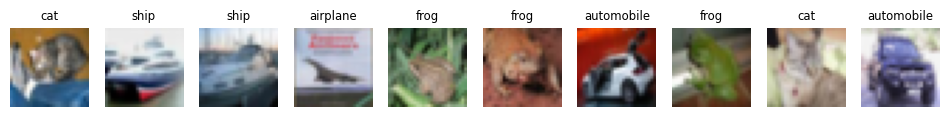

In [3]:
from matplotlib import pyplot as plt
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y}', fontsize='small')

### Next, we define the model and train it

In [4]:
from tqdm import tqdm
import sys
import torch, torch.nn as nn, torch.nn.functional as F

class MyCNNModel(nn.Module):
    def __init__(self, *layers, lr=0.01, classes=None):
        super().__init__() # <- Very important!
        self.lr = lr
        self.classes = classes
        ## Build model
        self.layers = nn.Sequential(*layers) # Create a sequential model
        
    def forward(self, X):
        return self.layers(X)
    
    def predict(self, X):
        with torch.no_grad():
            y_hat = self(X).argmax(1)
        if self.classes is not None:
            y_hat = [self.classes[i] for i in y_hat]
        return y_hat
    
    def train_step(self, X, y):
        y_hat = self(X)
        return F.cross_entropy(y_hat, y)
        
    def validation_step(self, X, y):
        with torch.no_grad():
            return self.train_step(X, y)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
        
    def fit(self, train_loader, valid_loader, epochs=10):
        ## Load Optimizer
        optimizer = self.configure_optimizers()
        
        for epoch in range(epochs):
            print(f'{epoch+1}/{epochs}:')
            # Training
            self.train() # Set model to training mode
            with tqdm(train_loader, unit="batch", desc='Train: ', colour='#1f77b4',\
                      file=sys.stdout, ncols=80) as tepoch:
                for X,y in tepoch:
                    optimizer.zero_grad(set_to_none=True) # Sets all gradients to Zero
                    loss = self.train_step(X, y) # Execute Forward pass
                    loss.backward() # Execute Backward pass
                    optimizer.step() # Update weights
                    tepoch.set_postfix(loss=f'{loss.item():1.4f}')
                    
            # Validation
            self.eval() # Set model to validation mode
            with tqdm(train_loader, unit="batch", desc='Valid: ', colour='#ff7f0e',\
                      file=sys.stdout, ncols=80) as tepoch:
                for X,y in tepoch:
                    loss_valid = self.validation_step(X, y)
                    tepoch.set_postfix(loss=f'{loss_valid.item():1.4f}')
            
        return self

In [5]:
model1 = MyCNNModel(
    nn.Conv2d(3, 6, (5,5), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, (5,5), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=testset.classes,
).fit(trainloader, testloader, epochs=10)

1/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 368.56batch/s, loss=1.6734]
2/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 369.10batch/s, loss=2.0863]
3/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 366.36batch/s, loss=1.4635]
4/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 361.56batch/s, loss=1.6427]
5/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 358.40batch/s, loss=1.3686]
6/10:
Valid: 100%|███████████████| 3125/3125 [00:08<00:00, 366.03batch/s, loss=1.6155]
7/10:
Train:  38%|█████▋         | 1185/3125 [00:06<00:10, 187.77batch/s, loss=1.4805]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Now, we can apply it

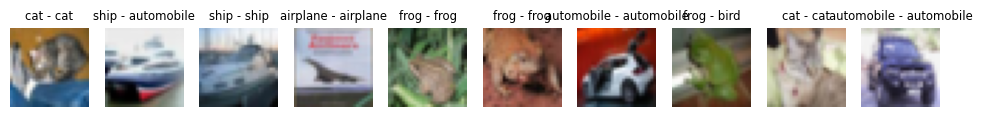

In [18]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model1.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

### Add more Conv Layers

In [7]:
model2 = MyCNNModel(
    nn.Conv2d(3, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(8, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=testset.classes,
).fit(trainloader, testloader, epochs=10)

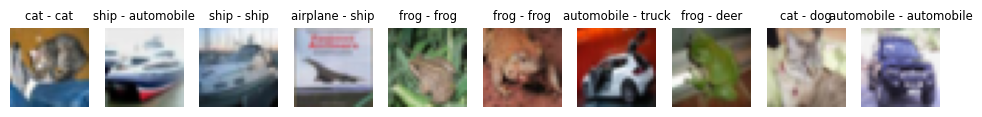

In [17]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model2.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

### More advance layers?

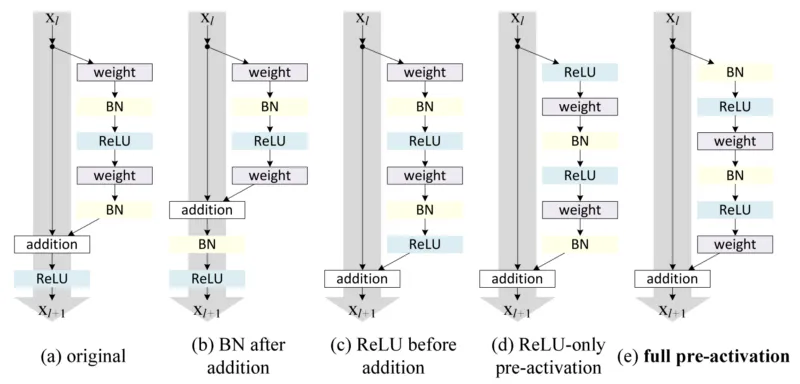

In [9]:
# Implement the original ResNet Layer.
# Find details on ResNet: https://arxiv.org/abs/1512.03385
# Find details on Batch Normalization: https://arxiv.org/abs/1502.03167
class MyResLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, **kwargs):
        super().__init__()
        if in_channels == out_channels:
            self.proj_out = nn.Identity()
        else:
            self.proj_out = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
            
        self.res_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel, **kwargs),
            nn.BatchNorm2d(out_channels),
            #nn.ReLU(),
        )
        
    def forward(self, x):
        x_res = self.res_block(x)
        x = self.proj_out(x)
        return  F.relu(x + x_res) #x + x_res

In [10]:
model3 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=testset.classes,
).fit(trainloader, testloader, epochs=10)

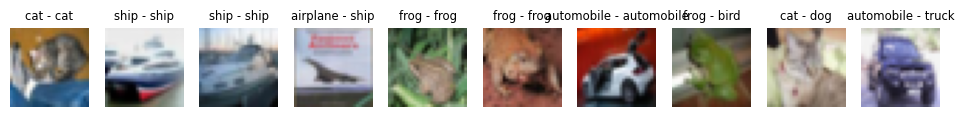

In [16]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model3.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

### Is Inception only a movie?

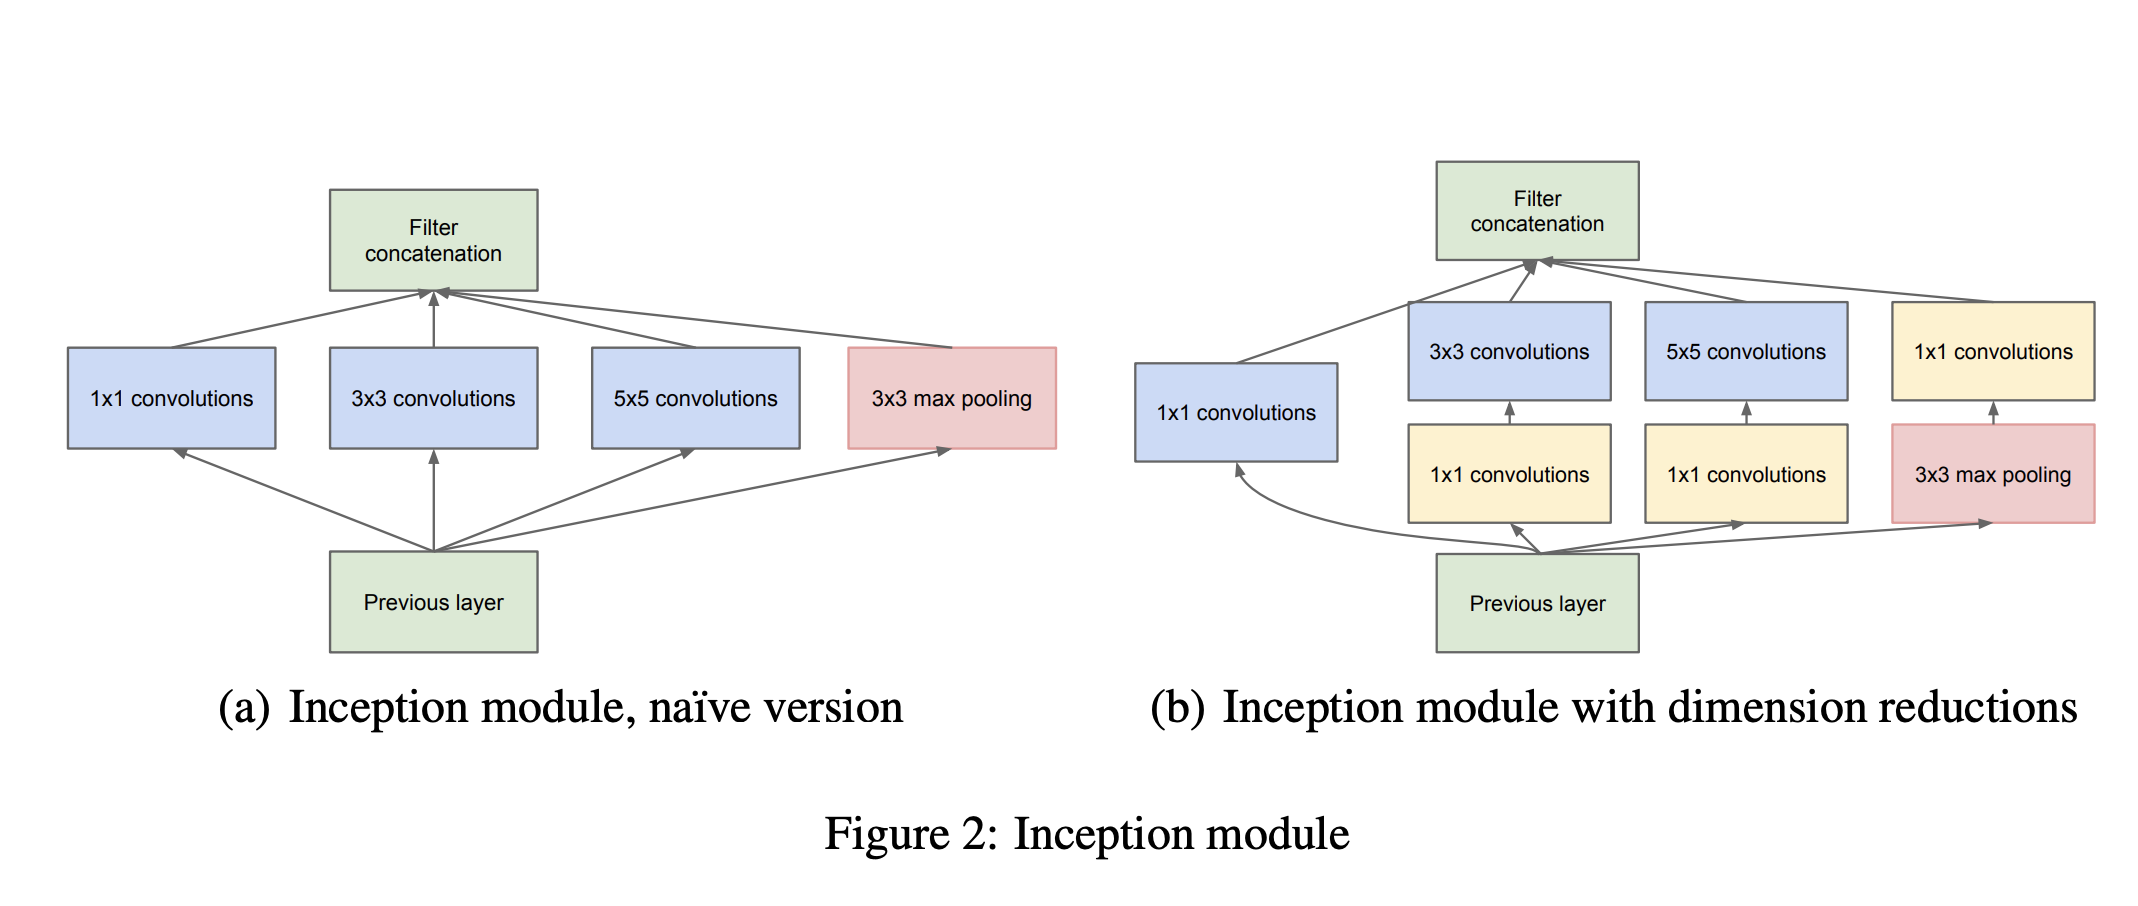

In [12]:
# Implement the naive version.
# Find details on inception: https://arxiv.org/abs/1409.4842
class MyInceptionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        out_channels = out_channels//4
        self.conv1x = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        self.conv3x = nn.Conv2d(in_channels, out_channels, (3,3), **kwargs)
        self.conv5x = nn.Conv2d(in_channels, out_channels, (5,5), **kwargs)
        
        self.poolx = nn.Sequential(
            nn.MaxPool2d((3,3), stride=(1,1), padding=1),
            nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        )
        
    def forward(self, x):
        x_1 = self.conv1x(x)
        x_2 = self.conv3x(x)
        x_3 = self.conv5x(x)
        x_p = self.poolx(x)
        x = torch.cat([x_1, x_2, x_3, x_p], dim=1)
        return F.relu(x)

In [13]:
model4 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyInceptionLayer(8, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=testset.classes,
).fit(trainloader, testloader, epochs=10)

Valid: 100%|███████████████| 3125/3125 [00:23<00:00, 132.49batch/s, loss=1.4221]
10/10:
Valid: 100%|███████████████| 3125/3125 [00:23<00:00, 134.93batch/s, loss=0.9856]


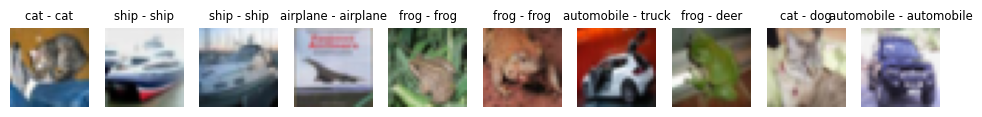

In [14]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model4.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

### Finally, how to count parameters?

In [15]:
print('Model 1:', sum(p.numel() for p in model1.parameters()))
print('Model 2:', sum(p.numel() for p in model2.parameters()))
print('Model 3:', sum(p.numel() for p in model3.parameters()))
print('Model 4:', sum(p.numel() for p in model4.parameters()))

Model 1: 3042
Model 2: 6786
Model 3: 15346
Model 4: 6786


In [5]:
X, y = trainset[0]

In [6]:
X.shape

torch.Size([3, 28, 28])

In [7]:
for batch in iter(trainloader):
    break

In [11]:
batch[1]

tensor([4, 4, 9, 7, 5, 9, 3, 4, 0, 0, 3, 2, 6, 4, 0, 6])